In [1]:
from google.colab import files
uploaded = files.upload()

Saving Womens Clothing E-Commerce Reviews.csv to Womens Clothing E-Commerce Reviews.csv


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-060c7245e9a2>:142: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `pro

Bắt đầu huấn luyện với các thay đổi...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,F1 Negative,F1 Positive
1,0.094000,0.260155,0.927598,0.858408,0.933716,0.759430,0.957387
2,0.066500,0.340801,0.958375,0.905672,0.959318,0.835165,0.976180
3,0.014200,0.416581,0.961150,0.909712,0.961563,0.841564,0.977861



Đánh giá mô hình tốt nhất trên tập test:


Kết quả đánh giá: {'eval_loss': 0.4165814220905304, 'eval_accuracy': 0.9611503531786074, 'eval_f1_macro': 0.9097123127855988, 'eval_f1_weighted': 0.9615629577806905, 'eval_f1_negative': 0.8415637860082305, 'eval_f1_positive': 0.9778608395629672, 'eval_runtime': 42.7516, 'eval_samples_per_second': 92.722, 'eval_steps_per_second': 11.602, 'epoch': 3.0}

Báo cáo phân loại chi tiết trên tập test:
              precision    recall  f1-score   support

    Negative     0.8213    0.8629    0.8416       474
    Positive     0.9812    0.9745    0.9779      3490

    accuracy                         0.9612      3964
   macro avg     0.9013    0.9187    0.9097      3964
weighted avg     0.9621    0.9612    0.9616      3964


Độ chính xác: 0.9611503531786074


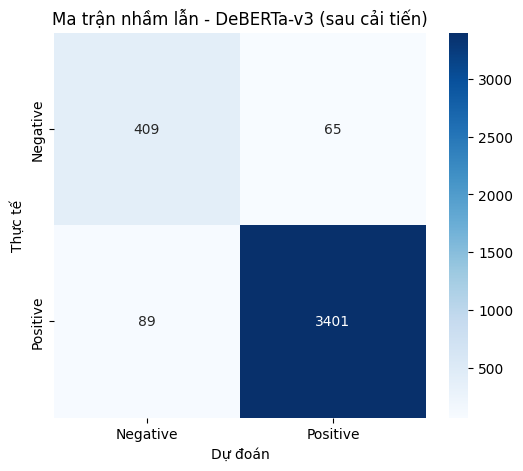

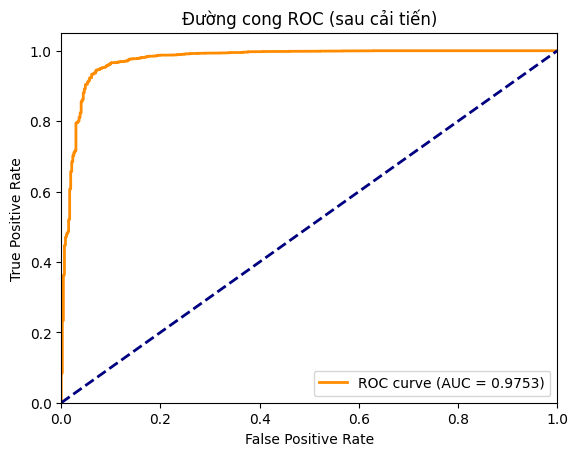


--- Kiểm thử mô hình trên đánh giá mới (sau cải tiến) ---
Đánh giá: This dress is fantastic! I love it!
→ Cảm xúc dự đoán: Positive (Độ tin cậy: 99.98%)

Đánh giá: The fabric is terrible and it ripped easily.
→ Cảm xúc dự đoán: Negative (Độ tin cậy: 99.98%)

Đánh giá: I am very satisfied with this purchase, great quality!
→ Cảm xúc dự đoán: Positive (Độ tin cậy: 99.98%)

Đánh giá: Poorly made, not worth the money.
→ Cảm xúc dự đoán: Negative (Độ tin cậy: 99.99%)

Đánh giá: Absolutely love this! Fits perfectly.
→ Cảm xúc dự đoán: Positive (Độ tin cậy: 99.98%)

Đánh giá: Not happy at all, bad experience.
→ Cảm xúc dự đoán: Negative (Độ tin cậy: 99.99%)

Đánh giá: Wonderful fabric and excellent design!
→ Cảm xúc dự đoán: Positive (Độ tin cậy: 99.89%)

Đánh giá: Size was incorrect and material feels cheap.
→ Cảm xúc dự đoán: Negative (Độ tin cậy: 99.99%)

Đánh giá: The product is okay, not great but not bad either.
→ Cảm xúc dự đoán: Positive (Độ tin cậy: 98.99%)

Đánh giá: I'm on the fen

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler # Thêm WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score # Thêm f1_score
from sklearn.utils.class_weight import compute_class_weight
import re
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments



# 1. Đọc và xử lý dữ liệu
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df = df[df['Rating'] != 3].dropna(subset=['Review Text', 'Rating'])
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x > 3 else 0)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip()
    return text

df['Cleaned'] = df['Review Text'].apply(clean_text)

# 2. Train-test split
X = df['Cleaned'].values
y = df['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3. Dataset cho DeBERTa-v3
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = ReviewDataset(X_train, y_train, tokenizer)
test_dataset = ReviewDataset(X_test, y_test, tokenizer)

# 4. Tải mô hình DeBERTa-v3 với head phân loại mới (2 lớp)
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-base",
    num_labels=2
)
model.config.pad_token_id = tokenizer.pad_token_id


def compute_metrics_detailed(eval_pred):
    labels = eval_pred.label_ids
    logits = eval_pred.predictions
    preds = np.argmax(logits, axis=1)

    accuracy = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, preds, average='weighted', zero_division=0)
    f1_negative = f1_score(labels, preds, labels=[0,1], pos_label=0, average='binary', zero_division=0)
    f1_positive = f1_score(labels, preds, labels=[0,1], pos_label=1, average='binary', zero_division=0)

    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "f1_negative": f1_negative,
        "f1_positive": f1_positive,
    }

training_args = TrainingArguments(
    output_dir='./results_v2', 
    num_train_epochs=3, 
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5, 
    logging_dir='./logs_v2',
    logging_steps=50, 
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,        
    seed=42,
    report_to=[] 
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class_counts = np.bincount(y_train)
class_weights_for_sampler = 1. / class_counts
sample_weights = np.array([class_weights_for_sampler[label] for label in y_train])
sample_weights_tensor = torch.from_numpy(sample_weights).double()
train_sampler = WeightedRandomSampler(weights=sample_weights_tensor, num_samples=len(sample_weights_tensor), replacement=True)
class_weights_for_loss_fn = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_for_loss_fn = torch.tensor(class_weights_for_loss_fn, dtype=torch.float).to(device)



class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights_loss=None, train_sampler_override=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights_loss = class_weights_loss
        self.train_sampler_override = train_sampler_override 

    def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=None):
        labels = inputs.pop("labels", None)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights_loss)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

    def get_train_dataloader(self) -> DataLoader:
        """
        Returns the training Dataloader.
        Overrides base Trainer method to incorporate custom sampler.
        """
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        train_dataset = self.train_dataset
        data_collator = self.data_collator 
        current_sampler = self.train_sampler_override if self.train_sampler_override is not None else super()._get_train_sampler()


        return DataLoader(
            train_dataset,
            batch_size=self._train_batch_size,
            sampler=current_sampler, 
            collate_fn=data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics_detailed, 
    tokenizer=tokenizer, 
    class_weights_loss=class_weights_for_loss_fn, 
    train_sampler_override=train_sampler        
)


# 6. Huấn luyện mô hình
print("Bắt đầu huấn luyện với các thay đổi...")
trainer.train()

# 7. Đánh giá trên tập test
print("\nĐánh giá mô hình tốt nhất trên tập test:")
model.eval() 
eval_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Kết quả đánh giá: {eval_results}")


all_preds, all_labels, all_probs = [], [], []
test_loader_for_final_eval = DataLoader(test_dataset, batch_size=training_args.per_device_eval_batch_size)

with torch.no_grad():
    for batch in test_loader_for_final_eval:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model(input_ids, attention_mask=attention_mask)

        probs_batch = torch.softmax(outputs.logits, dim=1)
        preds_batch = torch.argmax(probs_batch, dim=1)

        all_probs.extend(probs_batch[:, 1].cpu().numpy()) 
        all_labels.extend(labels.cpu().numpy())

print("\nBáo cáo phân loại chi tiết trên tập test:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"], digits=4))
print("\nĐộ chính xác:", accuracy_score(all_labels, all_preds))

# 8. Vẽ ma trận nhầm lẫn
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Ma trận nhầm lẫn - DeBERTa-v3 (sau cải tiến)")
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.show()

# 9. Vẽ ROC Curve
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Đường cong ROC (sau cải tiến)')
plt.legend(loc="lower right")
plt.show()

new_reviews = [
    "This dress is fantastic! I love it!",
    "The fabric is terrible and it ripped easily.",
    "I am very satisfied with this purchase, great quality!",
    "Poorly made, not worth the money.",
    "Absolutely love this! Fits perfectly.",
    "Not happy at all, bad experience.",
    "Wonderful fabric and excellent design!",
    "Size was incorrect and material feels cheap.",
    "The product is okay, not great but not bad either.", 
    "I'm on the fence about this one." 
]

def preprocess_and_encode_new(texts, tokenizer, max_len=128): 
    encodings = tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encodings['input_ids'], encodings['attention_mask']

input_ids_new, attention_mask_new = preprocess_and_encode_new(new_reviews, tokenizer)
input_ids_new = input_ids_new.to(model.device)
attention_mask_new = attention_mask_new.to(model.device)

model.eval()
with torch.no_grad():
    outputs_new = model(input_ids_new, attention_mask=attention_mask_new)
    probs_new = torch.softmax(outputs_new.logits, dim=1).cpu().numpy()
    preds_new = torch.argmax(outputs_new.logits, dim=1).cpu().numpy()

print("\n--- Kiểm thử mô hình trên đánh giá mới (sau cải tiến) ---")
for review, pred, prob_vector in zip(new_reviews, preds_new, probs_new):
    sentiment = "Positive" if pred == 1 else "Negative"
    confidence = prob_vector[pred] * 100
    print(f"Đánh giá: {review}\n→ Cảm xúc dự đoán: {sentiment} (Độ tin cậy: {confidence:.2f}%)\n")

In [1]:
model.save_pretrained("./saved_models/deberta")
tokenizer.save_pretrained("./saved_models/deberta")

NameError: name 'model' is not defined